Original data shape: (594, 786) Label counts: [142  39 128  39 130 116]
Class Names: ['CD9', 'CD63', 'CD81', 'Plasma Exo', 'MB', '4-NP']
Processed features shape: (594, 2363)
Train shape: (504, 2363) Test shape: (90, 2363)
Augmented TRAIN shape: (558, 2363) Label counts: [130  42 118  42 119 107]
PCA train shape: (558, 13) PCA test shape: (90, 13)


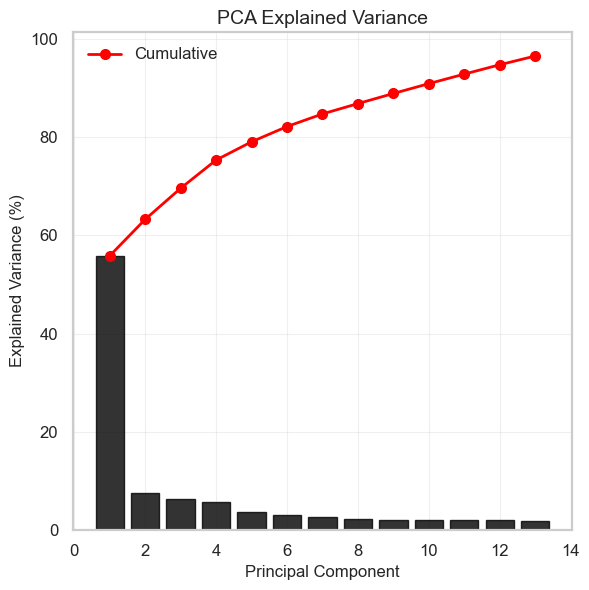

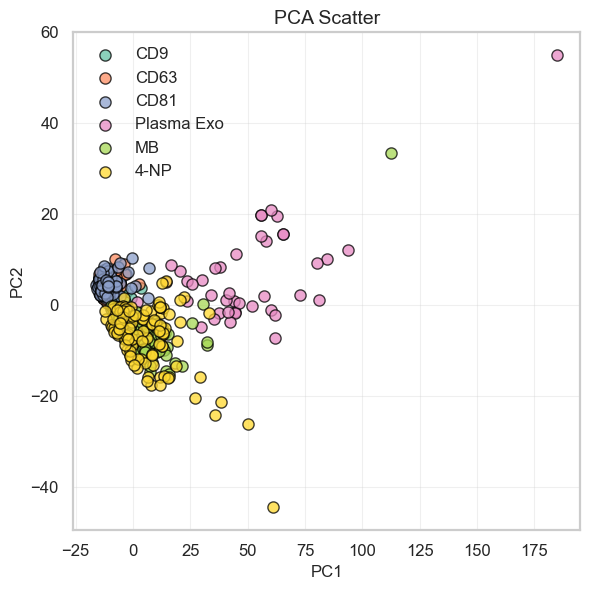

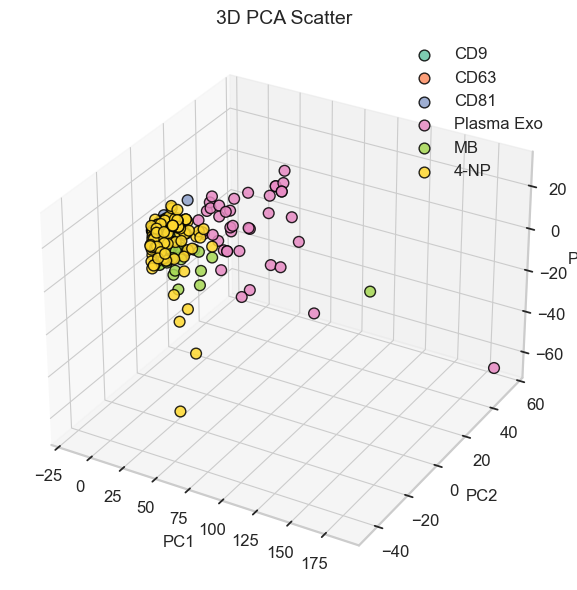


Training models...
  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        1.5394       0.7738        1.4593  0.0005  0.0702
      2        1.0715       0.8214        1.0941  0.0005  0.0667
      3        0.8034       0.8214        0.8856  0.0005  0.0557
      4        0.6583       0.8095        0.7911  0.0005  0.0528
      5        0.5659       0.8333        0.7153  0.0005  0.0605
      6        0.4900       0.8333        0.6738  0.0005  0.0540
      7        0.4575       0.8333        0.6378  0.0005  0.0605
      8        0.4411       0.8214        0.6152  0.0005  0.0587
      9        0.3885       0.8333        0.5979  0.0005  0.0526
     10        0.3769       0.8333        0.5914  0.0005  0.0525
     11        0.3676       0.8452        0.5875  0.0005  0.0552
     12        0.3605       0.8333        0.5846  0.0005  0.0560
     13        0.3210       0.8452        0.5696  0.0005  0.0536
     

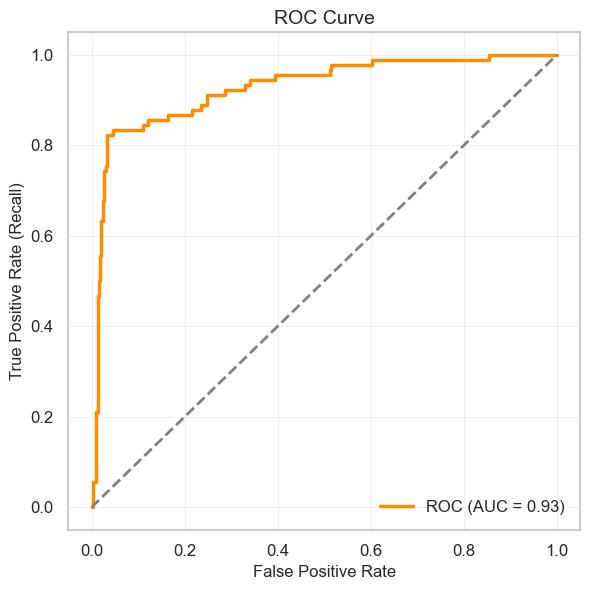

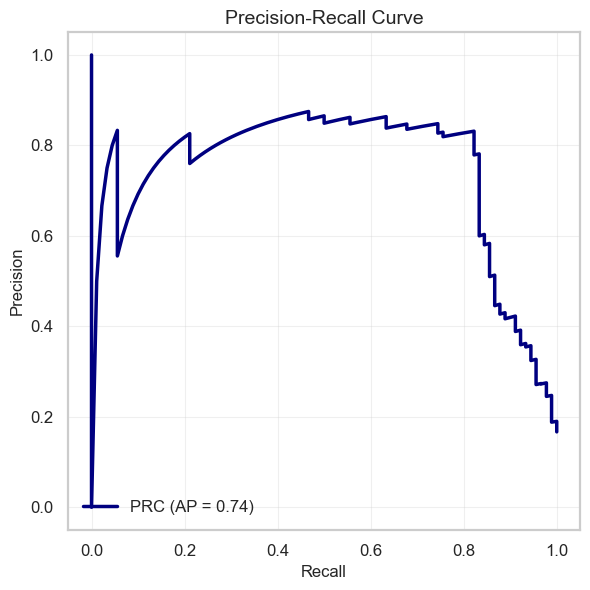

Best F1 score: 0.827

Test Set Performance:
              precision    recall  f1-score   support

         CD9       0.70      0.76      0.73        21
        CD63       1.00      0.17      0.29         6
        CD81       0.69      0.95      0.80        19
  Plasma Exo       1.00      1.00      1.00         6
          MB       0.95      0.90      0.92        20
        4-NP       1.00      0.83      0.91        18

    accuracy                           0.82        90
   macro avg       0.89      0.77      0.77        90
weighted avg       0.85      0.82      0.81        90



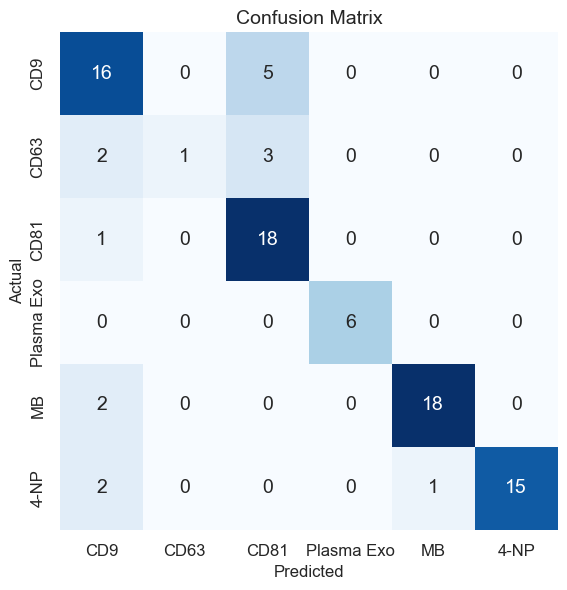

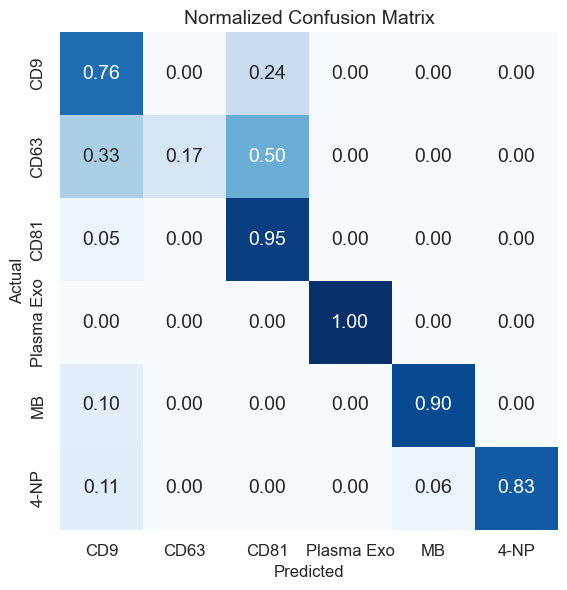

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        1.6819       0.7761        1.5176  0.0005  0.0473
      2        1.2243       0.8955        1.1411  0.0005  0.0818
      3        0.9583       0.9104        0.8675  0.0005  0.0553
      4        0.7947       0.8955        0.7130  0.0005  0.0511
      5        0.6877       0.8955        0.6023  0.0005  0.0490
      6        0.6052       0.8955        0.5380  0.0005  0.0445
      7        0.5522       0.8955        0.4779  0.0005  0.0502
      8        0.5140       0.9104        0.4511  0.0005  0.0500
      9        0.4626       0.9104        0.4282  0.0005  0.0500
     10        0.4546       0.9403        0.4084  0.0005  0.0433
     11        0.4361       0.9403        0.3726  0.0005  0.0405
     12        0.4105       0.9403        0.3531  0.0005  0.0447
     13        0.4035       0.9403        0.3429  0.0005  0.0379
     14        0.3749    

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, find_peaks
from BaselineRemoval import BaselineRemoval
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc, roc_curve, average_precision_score
from sklearn.preprocessing import StandardScaler, RobustScaler, label_binarize
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
import torch
import torch.nn as nn
from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping, LRScheduler
from skorch.dataset import ValidSplit
import seaborn as sns

# ---------------- General settings and reproducibility ---------------
plt.rcParams.update({
    'figure.figsize': (6, 6),
    'font.size': 10,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'axes.linewidth': 1.6,
    'xtick.major.size': 7,
    'xtick.major.width': 1.3,
    'ytick.major.size': 7,
    'ytick.major.width': 1.3,
    'lines.linewidth': 2,
    'lines.markersize': 7,
    'legend.frameon': False,
    'axes.grid': True,
    'grid.linestyle': '--',
    'grid.alpha': 0.3,
    'savefig.bbox': 'tight'
})
sns.set_style("whitegrid")
np.random.seed(42)
torch.manual_seed(42)

# ---------------- 1. Data loading ---------------
excel_path = "C:/Users/zhouj/OneDrive/Desktop/ML3.xlsx"
def load_data(excel_path):
    with pd.ExcelFile(excel_path) as xls:
        sheet_names = xls.sheet_names
        raman_shifts = None
        xs, labels = [], []
        for idx, name in enumerate(sheet_names):
            df = pd.read_excel(xls, sheet_name=name, header=None)
            if raman_shifts is None:
                raman_shifts = df.iloc[:, 0].values
            data = df.iloc[:, 1:].values.T.astype(np.float32)
            xs.append(data)
            labels += [idx] * data.shape[0]
    return raman_shifts, np.vstack(xs), np.array(labels), sheet_names

raman_shifts, X, y, class_names = load_data(excel_path)
print("Original data shape:", X.shape, "Label counts:", np.bincount(y))
print("Class Names:", class_names)

# ---------------- 2. Spectral preprocessing ---------------
def spectral_features(spectra, raman_shifts):
    # Extract number of peaks, strongest peak position, prominence, width, global std
    all_features = []
    for spectrum in spectra:
        peaks, props = find_peaks(spectrum, height=0.1, prominence=0.1, width=2)
        n_peaks = len(peaks)
        if n_peaks == 0:
            all_features.append(np.zeros(5, dtype=np.float32))
            continue
        main_peak_idx = np.argmax(props['prominences'])
        features = [
            n_peaks,
            raman_shifts[peaks[main_peak_idx]],
            props['prominences'][main_peak_idx],
            props['widths'][main_peak_idx],
            spectrum.std()
        ]
        all_features.append(np.array(features, dtype=np.float32))
    return np.vstack(all_features)

def preprocess_spectra(X, raman_shifts):
    # Baseline correction (try Zhang, fallback to ModPoly)
    try:
        Xcorr = np.stack([BaselineRemoval(row).ZhangFit() for row in X]).astype(np.float32)
    except:
        Xcorr = np.stack([BaselineRemoval(row).ModPoly() for row in X]).astype(np.float32)
    # Smooth (adaptive window size)
    window_size = min(15, Xcorr.shape[1]//10*2+1)
    Xsmooth = savgol_filter(Xcorr, window_size, 2, axis=1).astype(np.float32)
    # Derivatives, peak features, and scaling
    peak_features = spectral_features(Xsmooth, raman_shifts)
    X_deriv1 = np.gradient(Xsmooth, axis=1).astype(np.float32)
    X_deriv2 = np.gradient(X_deriv1, axis=1).astype(np.float32)
    X_combined = np.hstack((
        RobustScaler().fit_transform(Xsmooth),
        X_deriv1,
        X_deriv2,
        peak_features
    )).astype(np.float32)
    return X_combined

X_proc = preprocess_spectra(X, raman_shifts)
print("Processed features shape:", X_proc.shape)

# ---------------- 3. Train/test split ---------------
X_train, X_test, y_train, y_test = train_test_split(
    X_proc, y, test_size=0.15, stratify=y, random_state=42
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

# ---------------- 4. Data augmentation on training set ---------------
def spectral_augmentation(X, y, n_aug=3):
    X_aug, y_aug = [], []
    for class_idx in np.unique(y):
        class_data = X[y == class_idx]
        for _ in range(n_aug):
            base = class_data[np.random.choice(len(class_data))]
            noise = np.random.normal(0, 0.02, base.shape).astype(np.float32)
            shifted = np.roll(base, np.random.randint(-5,5)).astype(np.float32)
            scaled = (base * np.random.uniform(0.9, 1.1)).astype(np.float32)
            X_aug.extend([base + noise, shifted, scaled])
            y_aug.extend([class_idx]*3)
    return np.vstack([X, X_aug]), np.hstack([y, y_aug])
X_train_aug, y_train_aug = spectral_augmentation(X_train, y_train)
print("Augmented TRAIN shape:", X_train_aug.shape, "Label counts:", np.bincount(y_train_aug))

# ---------------- 5. Dimensionality reduction (PLS then PCA) ---------------
pls = PLSRegression(n_components=15)
pls.fit(X_train_aug, y_train_aug)
X_train_pls = pls.transform(X_train_aug).astype(np.float32)
X_test_pls = pls.transform(X_test).astype(np.float32)
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_pls).astype(np.float32)
X_test_pca = pca.transform(X_test_pls).astype(np.float32)
print("PCA train shape:", X_train_pca.shape, "PCA test shape:", X_test_pca.shape)

# ---------------- PCA figures ---------------
explained_var = pca.explained_variance_ratio_
plt.figure()
plt.bar(range(1, len(explained_var)+1), explained_var*100, color='k', alpha=0.8, edgecolor='k')
plt.plot(range(1, len(explained_var)+1), np.cumsum(explained_var)*100, 'r-o', linewidth=2, label='Cumulative')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance (%)')
plt.title('PCA Explained Variance')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

palette = sns.color_palette("Set2", n_colors=len(class_names))
plt.figure()
for i, cl in enumerate(class_names):
    plt.scatter(
        X_train_pca[y_train_aug==i, 0], X_train_pca[y_train_aug==i, 1],
        label=cl, color=palette[i], s=65, edgecolor='k', marker='o', alpha=0.75)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Scatter')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i, cl in enumerate(class_names):
    ax.scatter(
        X_train_pca[y_train_aug==i, 0], X_train_pca[y_train_aug==i, 1], X_train_pca[y_train_aug==i, 2],
        label=cl, color=palette[i], s=60, edgecolor='k', alpha=0.85)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D PCA Scatter')
ax.legend(loc='best')
plt.tight_layout()
plt.show()

# ---------------- 6. Model definitions ----------------
# Gradient Boosting, SVM, neural network, ensemble

gb = GradientBoostingClassifier(
    n_estimators=500, learning_rate=0.05, max_depth=5, subsample=0.8, random_state=42
)
svm = CalibratedClassifierCV(
    SVC(kernel='rbf', C=10, gamma='auto', class_weight='balanced', probability=True),
    cv=5
)
class SpectralNet(nn.Module):
    def __init__(self, input_dim, n_classes):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Linear(128, n_classes)
        )
    def forward(self, x):
        x = x.to(torch.float32)
        return self.main(x)

nn_clf = NeuralNetClassifier(
    SpectralNet,
    module__input_dim=X_train_pca.shape[1],
    module__n_classes=len(class_names),
    max_epochs=100,
    lr=0.0005,
    optimizer=torch.optim.AdamW,
    criterion=nn.CrossEntropyLoss,
    batch_size=32,
    callbacks=[
        EarlyStopping(patience=15),
        LRScheduler(policy='CosineAnnealingLR', T_max=100)
    ],
    device='cuda' if torch.cuda.is_available() else 'cpu',
    train_split=ValidSplit(0.15),
    iterator_train__shuffle=True,
    verbose=1,
)

ensemble = VotingClassifier(
    estimators=[
        ('gb', gb),
        ('svm', svm),
        ('nn', nn_clf)
    ],
    voting='soft',
    weights=[2, 1, 1]
)

# ---------------- 7. Feature scaling ---------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_pca).astype(np.float32)
X_test_scaled = scaler.transform(X_test_pca).astype(np.float32)

# ---------------- 8. Model training ---------------
print("\nTraining models...")
ensemble.fit(X_train_scaled, y_train_aug)

# (Optional) Plot neural net loss
history = getattr(nn_clf, 'history', None)
if history is not None and len(history) > 0:
    plt.figure()
    losses = [h['train_loss'] for h in history]
    plt.plot(losses, 'o-', color='b', label='Train Loss')
    if 'valid_loss' in history[0]:
        val_losses = [h['valid_loss'] for h in history]
        plt.plot(val_losses, 's-', color='r', label='Valid Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Neural Network Training')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

# ---------------- 9. Test set prediction and metrics ---------------
y_test_bin = label_binarize(y_test, classes=np.arange(len(class_names)))
val_probs = ensemble.predict_proba(X_test_scaled)
fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), val_probs.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)
precision_micro, recall_micro, _ = precision_recall_curve(y_test_bin.ravel(), val_probs.ravel())
prc_auc_micro = average_precision_score(y_test_bin, val_probs, average='micro')

plt.figure()
plt.plot(fpr_micro, tpr_micro, color='darkorange', lw=2.5, label=f'ROC (AUC = {roc_auc_micro:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(recall_micro, precision_micro, color='navy', lw=2.5, label=f'PRC (AP = {prc_auc_micro:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()
f1_scores = 2 * (precision_micro * recall_micro) / (precision_micro + recall_micro + 1e-8)
best_index = np.argmax(f1_scores)
best_f1 = f1_scores[best_index]
print(f'Best F1 score: {best_f1:.3f}')

y_pred = ensemble.predict(X_test_scaled)
print("\nTest Set Performance:")
print(classification_report(y_test, y_pred, target_names=class_names))
cm = confusion_matrix(y_test, y_pred)
plt.figure()
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=class_names, yticklabels=class_names,
    square=True, cbar=False, annot_kws={"size":14}
)
plt.title("Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure()
sns.heatmap(
    cm_normalized, annot=True, fmt='.2f', cmap='Blues',
    xticklabels=class_names, yticklabels=class_names,
    square=True, cbar=False, annot_kws={"size":14}
)
plt.title("Normalized Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

# ---------------- Feature importances (GB only) ---------------
if hasattr(gb, 'feature_importances_'):
    importances = gb.feature_importances_
    idxs = np.argsort(importances)[::-1]
    plt.figure()
    plt.bar(range(12), importances[idxs[:12]], color='slateblue', alpha=0.85, edgecolor='k')
    plt.xticks(range(12), [f'F{int(i)}' for i in idxs[:12]], rotation=30, ha='right')
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.title('Top 12 Feature Importances (GB)')
    plt.tight_layout()
    plt.show()

# ---------------- Cross-validation ---------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(ensemble, X_train_scaled, y_train_aug, cv=cv, scoring='accuracy')
print("Cross-validated accuracy (train_aug): %.2f ± %.2f" % (scores.mean(), scores.std()))
